In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import os
import datetime
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', 500)
from __future__ import print_function
import math
import csv
import glob

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std


# visualization
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
%matplotlib inline

#sentiment analysis
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords


# technical analaysis  
import talib

# machine learning
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn.preprocessing import MinMaxScaler

## data import

In [2]:
tweet_df = pd.read_csv('data/processed_tweet_data.csv')

In [2]:
tweet_df = pd.read_csv('data/processed_tweet_data_1042-rows.csv')

In [27]:
tweet_df = pd.read_csv('data/processed_tweet_data_1030-rows.csv')

In [28]:
tweet_df.describe()

,Unnamed: 0,tweet_len,sentiment_score_textBlob,sentiment_score_vader,pos_tweet_textBlob,neu_tweet_textBlob,neg_tweet_textBlob,pos_tweet_vader,neu_tweet_vader,neg_tweet_vader,pos-neg_textBlob,pos-neg_vader,neg-plus-neu_textBlob,posNeg-plusNeu_textBlob,neg-plus-neu_vader,posNeg-plusNeu_vader,signal_textBlob,signal_vader
count,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0
mean,516.5,168264.3,259.8,214.2,372.8,676.9,113.0,549.8,461.6,151.3,259.8,398.6,789.9,-417.1,612.9,-63.0,-0.9,-0.3
std,297.5,185631.9,276.6,231.3,397.8,724.9,128.3,589.1,494.6,169.8,276.6,428.8,849.2,461.0,659.9,136.7,0.4,1.0
min,2.0,5338.0,3.0,-2.0,14.0,18.0,0.0,16.0,13.0,1.0,3.0,9.0,21.0,-1303.0,19.0,-622.0,-1.0,-1.0
25%,259.2,14829.2,34.0,26.0,43.0,69.0,8.0,61.2,48.0,11.0,34.0,48.0,78.0,-931.5,60.0,-96.5,-1.0,-1.0
50%,516.5,32402.0,68.0,53.6,84.0,159.0,24.0,129.5,109.0,32.0,68.0,101.0,182.5,-101.5,142.0,-15.0,-1.0,-1.0
75%,773.8,400549.5,562.8,471.1,840.8,1554.8,248.0,1250.8,1050.8,331.0,562.8,882.0,1842.8,-33.2,1403.0,9.0,-1.0,1.0
max,1031.0,448986.0,903.0,736.3,1108.0,1801.0,465.0,1599.0,1301.0,614.0,903.0,1324.0,2048.0,35.0,1699.0,487.0,1.0,1.0


In [29]:
#tweet_df.head()
tweet_df = tweet_df.drop(columns='Unnamed: 0')

In [5]:
price_df = pd.read_csv('data/processed_btc_price_data_2014-12-01_to_2018-11-11.csv')

In [30]:
#price_df = price_df.drop(columns='Unnamed: 0')
price_df.head()

,date,Close
0,2014-12-01,335.0
1,2014-12-02,377.9
2,2014-12-03,377.7
3,2014-12-05,378.0
4,2014-12-08,375.0


## Merge: price and tweet

In [31]:
price_tweet_df = (price_df.merge(tweet_df, on='date'))

In [32]:
price_tweet_df.describe()

,Close,tweet_len,sentiment_score_textBlob,sentiment_score_vader,pos_tweet_textBlob,neu_tweet_textBlob,neg_tweet_textBlob,pos_tweet_vader,neu_tweet_vader,neg_tweet_vader,pos-neg_textBlob,pos-neg_vader,neg-plus-neu_textBlob,posNeg-plusNeu_textBlob,neg-plus-neu_vader,posNeg-plusNeu_vader,signal_textBlob,signal_vader
count,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0
mean,4009.0,170184.7,262.9,216.8,377.2,684.9,114.2,556.6,466.8,152.9,262.9,403.6,799.1,-422.0,619.7,-63.2,-0.9,-0.3
std,4106.9,185830.5,277.3,232.0,398.6,725.9,128.4,590.5,494.9,170.1,277.3,430.0,850.3,461.4,660.4,136.1,0.4,0.9
min,199.8,5338.0,3.0,-2.0,14.0,18.0,0.0,16.0,13.0,1.0,3.0,9.0,21.0,-1303.0,19.0,-622.0,-1.0,-1.0
25%,516.5,15028.8,34.0,26.3,43.0,70.0,8.0,63.0,48.0,11.0,34.0,49.0,78.0,-934.2,60.0,-98.2,-1.0,-1.0
50%,2342.8,33416.0,70.0,56.3,87.5,167.0,24.0,131.0,114.0,33.0,70.0,104.5,190.0,-106.0,147.0,-15.5,-1.0,-1.0
75%,6705.8,401183.2,566.0,472.1,844.0,1556.2,249.0,1254.0,1052.5,333.0,566.0,887.2,1844.0,-34.0,1404.2,9.0,-1.0,1.0
max,19419.9,448986.0,903.0,736.3,1108.0,1801.0,465.0,1599.0,1301.0,614.0,903.0,1324.0,2048.0,35.0,1699.0,487.0,1.0,1.0


In [33]:
price_tweet_df.head()

,date,Close,tweet_len,sentiment_score_textBlob,sentiment_score_vader,pos_tweet_textBlob,neu_tweet_textBlob,neg_tweet_textBlob,pos_tweet_vader,neu_tweet_vader,neg_tweet_vader,pos-neg_textBlob,pos-neg_vader,neg-plus-neu_textBlob,posNeg-plusNeu_textBlob,neg-plus-neu_vader,posNeg-plusNeu_vader,signal_textBlob,signal_vader
0,2014-12-08,375.0,16414.0,28.0,34.1,56.0,58.0,28.0,78.0,41.0,23.0,28.0,55.0,86.0,-30.0,64.0,14.0,-1,1
1,2014-12-18,340.0,9518.0,28.0,23.1,31.0,44.0,3.0,47.0,20.0,11.0,28.0,36.0,47.0,-16.0,31.0,16.0,-1,1
2,2015-01-12,260.0,13965.0,26.0,32.9,34.0,77.0,8.0,69.0,42.0,8.0,26.0,61.0,85.0,-51.0,50.0,19.0,-1,1
3,2015-01-15,207.6,13759.0,30.0,34.3,40.0,68.0,10.0,70.0,40.0,8.0,30.0,62.0,78.0,-38.0,48.0,22.0,-1,1
4,2015-01-16,203.0,9236.0,9.0,15.6,20.0,45.0,11.0,37.0,28.0,11.0,9.0,26.0,56.0,-36.0,39.0,-2.0,-1,-1


In [34]:
len(price_tweet_df)

1012

## OLS Regression

In [9]:
price_tweet_model = ols("""pos_sentiment_tweet ~ Close""", data=price_tweet_df).fit()

price_tweet_model_summary = price_tweet_model.summary()
price_tweet_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pos_sentiment_tweet   R-squared:                       0.112
Model:                             OLS   Adj. R-squared:                  0.111
Method:                  Least Squares   F-statistic:                     128.8
Date:                 Thu, 24 Jan 2019   Prob (F-statistic):           3.47e-28
Time:                         19:19:27   Log-Likelihood:                -9992.3
No. Observations:                 1021   AIC:                         1.999e+04
Df Residuals:                     1019   BIC:                         2.000e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -57.1211    187.905     -0.304      0.761    -425.846     311.603
Close          0.3732      0.033     11.347      0.000       0.309       0.438
==============================================================================
Omnibus:                     1731.359   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1152313.342
Skew:                          10.924   Prob(JB):                         0.00
Kurtosis:                     166.124   Cond. No.                     7.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
price_tweet_model = ols("""pos_tweet_textBlob ~ Close""", data=price_tweet_df).fit()

price_tweet_model_summary = price_tweet_model.summary()
price_tweet_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     pos_tweet_textBlob   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     3480.
Date:                Thu, 24 Jan 2019   Prob (F-statistic):               0.00
Time:                        21:07:26   Log-Likelihood:                -6740.5
No. Observations:                1012   AIC:                         1.348e+04
Df Residuals:                    1010   BIC:                         1.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5714      8.312      4.159      0.000      18.261      50.881
Close          0.0855      0.001     58.992      0.000       0.083       0.088
==============================================================================
Omnibus:                       57.797   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.587
Skew:                          -0.252   Prob(JB):                     8.16e-36
Kurtosis:                       4.891   Cond. No.                     8.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
price_tweet_model = ols("""pos_tweet_vader ~ Close""", data=price_tweet_df).fit()

price_tweet_model_summary = price_tweet_model.summary()
price_tweet_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        pos_tweet_vader   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     3190.
Date:                Thu, 24 Jan 2019   Prob (F-statistic):          7.89e-315
Time:                        21:07:50   Log-Likelihood:                -7171.8
No. Observations:                1012   AIC:                         1.435e+04
Df Residuals:                    1010   BIC:                         1.436e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.2468     12.729      4.262      0.000      29.269      79.224
Close          0.1253      0.002     56.481      0.000       0.121       0.130
==============================================================================
Omnibus:                       91.045   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.742
Skew:                          -0.517   Prob(JB):                     3.86e-47
Kurtosis:                       5.000   Cond. No.                     8.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

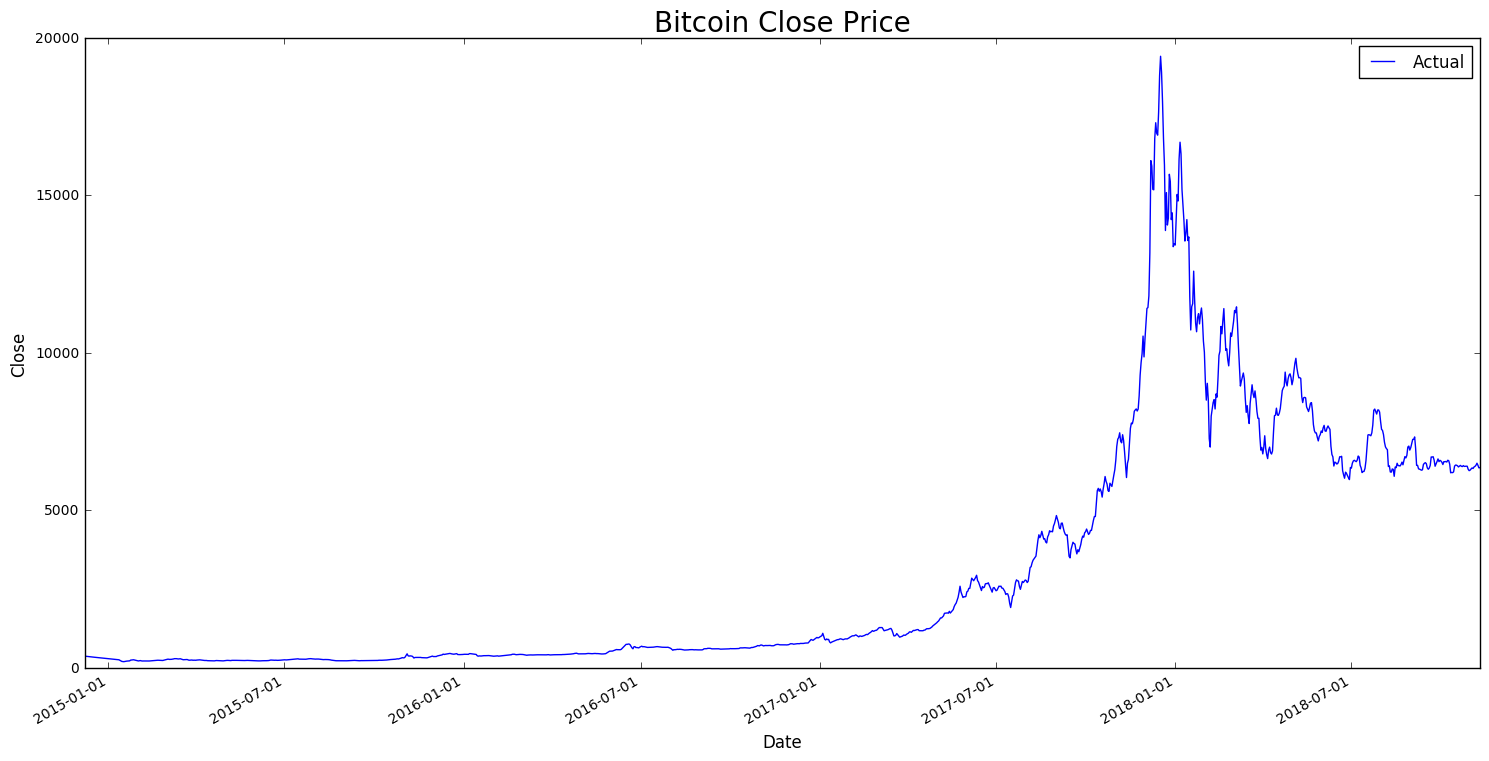

In [10]:
#preproces date col
dates_list_actual = list(price_tweet_df['date'])
dates_list_formatted_actual = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_actual]

# dates_list_training = list(price_tweet_df_training['date'])
# dates_list_formatted_training = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_training]

#dates_list_test = list(price_tweet_df['date'].tail(212))
#dates_list_formatted_test = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_test]

# price visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(dates_list_formatted_actual, price_tweet_df['Close'], color='b', label='Actual')
#plt.plot(dates_list_formatted_training, predictions, color='red', label='Training')
#plt.plot(dates_list_formatted_test, test_predictions, color='red', label='Test-Predicted')

plt.xlabel('Date',fontsize=12)
plt.ylabel('Close',fontsize=12)
plt.gcf().autofmt_xdate()
plt.title('Bitcoin Close Price',fontsize=20)
plt.ylim(-1,20000)
plt.legend()

In [ ]:
# Sentiment visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=0))

plt.plot(dates_list_formatted, price_tweet_df['sentiment'])
plt.xlabel('Date',fontsize=12)
plt.ylabel('sentiment',fontsize=12)
plt.gcf().autofmt_xdate()
plt.title('sentiment',fontsize=20)

## tensorflow: LinearRegressor

In [38]:
# training test split
price_tweet_df_training = price_tweet_df[:800]
price_tweet_df_test = price_tweet_df[800:]


In [49]:
len(price_tweet_df_test)

212

In [45]:
def preprocess_features(price_tweet_df):
    """Prepares input features from price_tweet_dfdata set.

  Args:
    price_tweet_df: A Pandas DataFrame expected to contain feature data
  Returns:
    A DataFrame that contains the features to be used for the model.
  """
    selected_features = price_tweet_df[["pos_tweet_textBlob"]]
    processed_features = selected_features.copy()
    
    return processed_features

def preprocess_targets(price_tweet_df):
    """Prepares target features (i.e., labels) from price_tweet_df data set.

  Args:
    price_tweet_df: A Pandas DataFrame expected to contain target data
     
  Returns:
    A DataFrame that contains the target feature.
  """
    output_targets = pd.DataFrame()
    output_targets["Close"] = price_tweet_df["Close"]
    
    return output_targets

In [42]:
def my_input_fn(features, targets, batch_size=1, shuffle=False, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
            
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [46]:
def train_model(learning_rate, steps, batch_size, input_feature="pos_tweet_textBlob"):
    """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `price_tweet_df`
      to use as input feature.
  """
    periods = 10
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = price_tweet_df_training[[my_feature]]
    my_label = "Close"
    targets = price_tweet_df_training[my_label]
    
    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = price_tweet_df.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
        )
        
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss.
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                  sample[my_feature].max()),
                           sample[my_feature].min())
        
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data.
    calibration_data_final = pd.DataFrame()
    calibration_data_final["predictions"] = pd.Series(predictions)
    calibration_data_final["targets"] = pd.Series(targets)
    display.display(calibration_data_final.describe())
    
    #preproces date col
    dates_list_actual = list(price_tweet_df['date'])
    dates_list_formatted_actual = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_actual]

    dates_list_training = list(price_tweet_df_training['date'])
    dates_list_formatted_training = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_training]

    #dates_list_test = list(price_tweet_df['date'].tail(212))
    #dates_list_formatted_test = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_test]

    # price visualization
    plt.figure(figsize = (18,9))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=0))

    plt.plot(dates_list_formatted_actual, price_tweet_df['Close'], color='b', label='Actual')
    plt.plot(dates_list_formatted_training, predictions, color='red', label='Training')
    #plt.plot(dates_list_formatted_test, test_predictions, color='red', label='Test-Predicted')

    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Close',fontsize=12)
    plt.gcf().autofmt_xdate()
    plt.title('Bitcoin Close Price',fontsize=20)
    plt.ylim(-1,20000)
    plt.legend()
    
    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
    
    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 1843.78
  period 01 : 1843.27
  period 02 : 1842.76
  period 03 : 1842.28
  period 04 : 1841.84
  period 05 : 1841.42
  period 06 : 1841.04
  period 07 : 1840.69
  period 08 : 1840.37
  period 09 : 1840.08
Model training finished.


,predictions,targets
count,800.0,800.0
mean,2916.1,3185.6
std,4056.9,4226.2
min,174.8,199.8
25%,468.7,422.6
50%,727.4,916.4
75%,2023.7,4359.6
max,13037.8,19419.9


Final RMSE (on training data): 1840.08


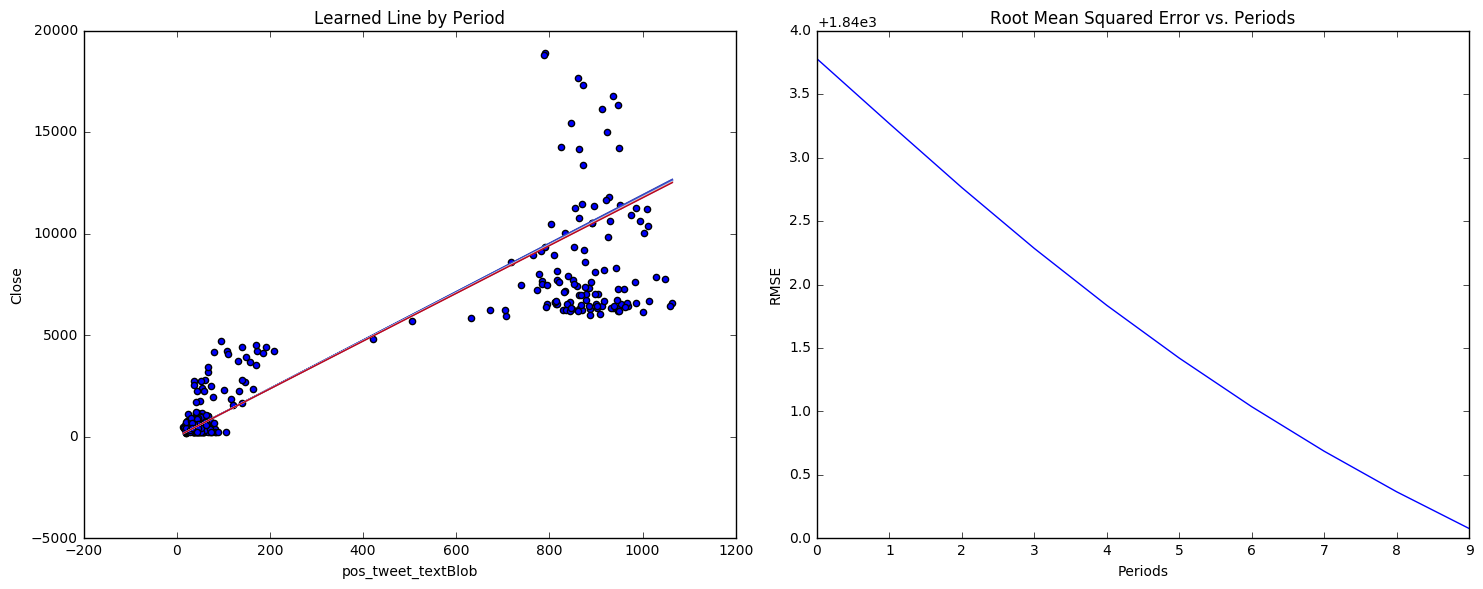

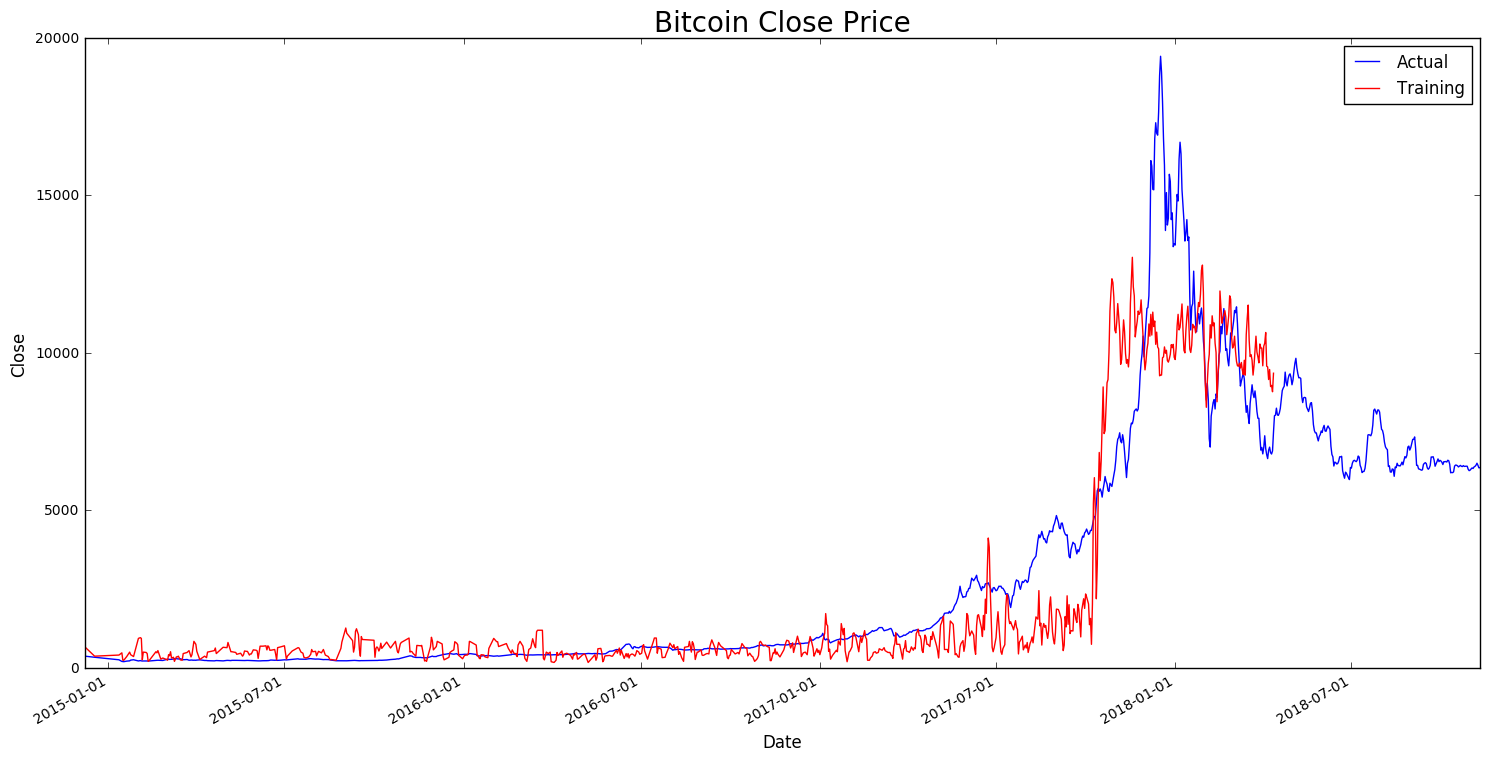

In [47]:
linear_regressor = train_model(
    learning_rate=0.2,
    steps=500,
    batch_size=5)

## Evaluate on Test data

In [48]:
price_tweet_df_test = price_tweet_df[800:]

test_examples = preprocess_features(price_tweet_df_test)
test_targets = preprocess_targets(price_tweet_df_test)

predict_test_input_fn = lambda: my_input_fn(
    test_examples, 
    test_targets['Close'], 
    num_epochs=1, 
    shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))
print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 3420.21


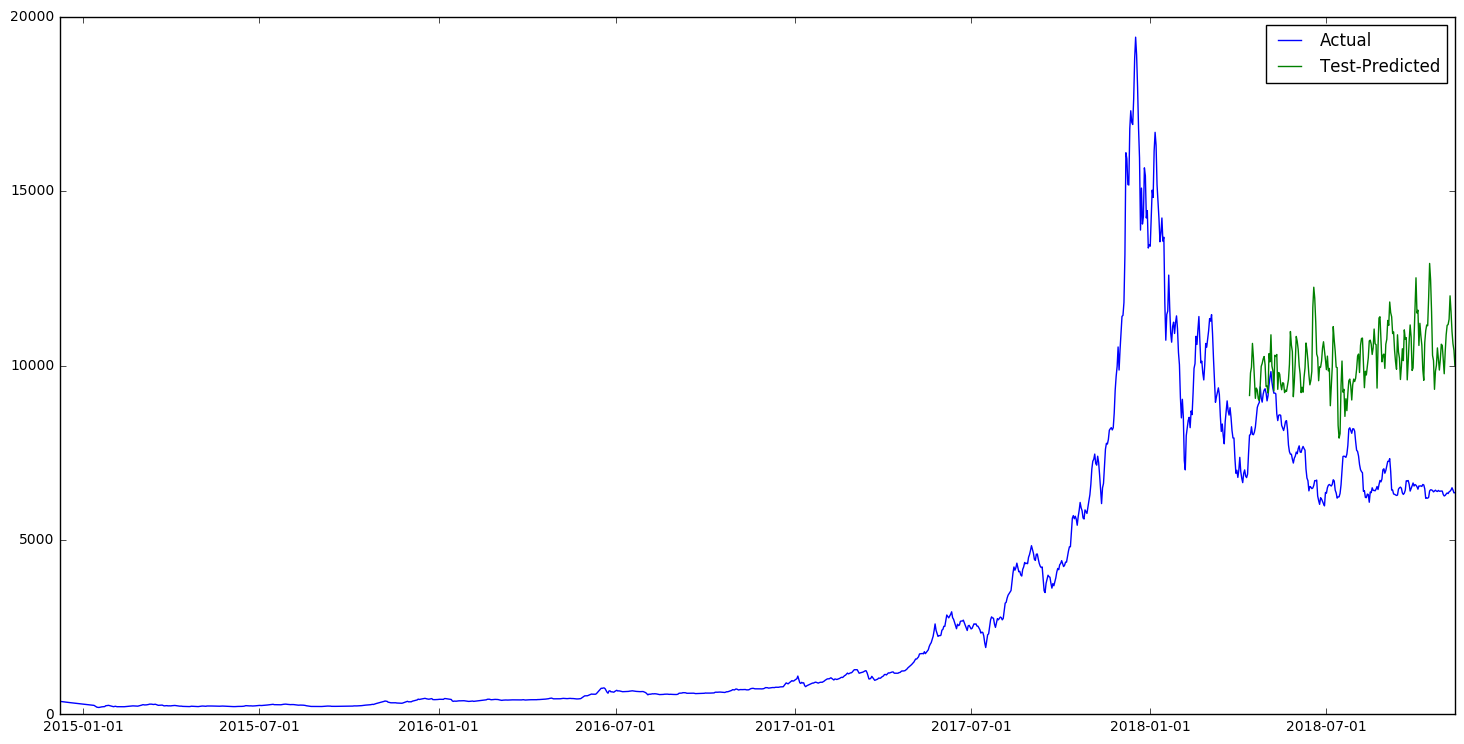

In [50]:
#preproces date col
dates_list_actual = list(price_tweet_df['date'])
dates_list_formatted_actual = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_actual]

# dates_list_training = list(price_tweet_df_training['date'])
# dates_list_formatted_training = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_training]

dates_list_test = list(price_tweet_df_test['date'].tail(212))
dates_list_formatted_test = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_test]

# price visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(dates_list_formatted_actual, price_tweet_df['Close'], color='b', label='Actual')
#plt.plot(dates_list_formatted_training, predictions, color='red', label='Training')
plt.plot(dates_list_formatted_test, test_predictions, color='green', label='Test-Predicted')
plt.legend()

In [4]:
#type(price_df['date'])
dates_list = list(price_df['date'])
#dates_list[0:10]
#type(price_df['date'][0])
dates_list_formatted = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list]


# price visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=0))

plt.plot(dates_list_formatted, price_df['Close'])
plt.xlabel('Date',fontsize=12)
plt.ylabel('Close Price',fontsize=12)
plt.gcf().autofmt_xdate()
plt.title('Bitcoin Close Price',fontsize=20)